In [48]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import numpy as np
from numpy.fft import fft, rfft
from scipy import signal
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [49]:
#% run outils.py # les fonctions perso et les imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

### Import CSV

In [50]:
dtype = {'Respiration':np.float64, 'GSR':np.float64, 'Temperature':np.float64, 'CFM':np.float64}
data = pd.read_csv('../data/AB.csv', sep = ';', decimal =',', dtype = dtype)

In [51]:
data.head(5)

,date,Respiration,GSR,Temperature,CFM
0,06/03/2014 15:19:29.756,-10.644,-44.157,29.417,74.0
1,06/03/2014 15:19:29.787,-10.379,-44.157,29.417,74.0
2,06/03/2014 15:19:29.819,-10.168,-44.157,29.417,74.0
3,06/03/2014 15:19:29.850,-9.981,-44.157,29.417,74.0
4,06/03/2014 15:19:29.881,-9.833,-44.169,29.417,74.0


In [53]:
# Vérification des types
print(type(data['Respiration'][0]))
print(type(data['GSR'][0]))
print(type(data['Temperature'][0]))
print(type(data['CFM'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


### Conversion des dates, création de la matrice des données

In [54]:
dates = []
for date in data['date']:
    dates.append(datetime.strptime(date, '%d/%m/%Y %H:%M:%S.%f'))
print(dates[:5])

[datetime.datetime(2014, 3, 6, 15, 19, 29, 756000), datetime.datetime(2014, 3, 6, 15, 19, 29, 787000), datetime.datetime(2014, 3, 6, 15, 19, 29, 819000), datetime.datetime(2014, 3, 6, 15, 19, 29, 850000), datetime.datetime(2014, 3, 6, 15, 19, 29, 881000)]


In [55]:
t = []
for date in dates:
    t.append((date-dates[0]).total_seconds())
time = Series(t, name='t')
#time.head(5)

In [56]:
print("Durée totale de l'expérience en secondes : ", t[-1])

Durée totale de l'expérience en secondes :  1525.063


In [57]:
X = DataFrame(data[['Respiration', 'GSR', 'Temperature', 'CFM']], columns = ['t', 'Respiration', 'GSR', 'Temperature', 'CFM'])
X['t'] = time
X.head(5)

,t,Respiration,GSR,Temperature,CFM
0,0.000,-10.644,-44.157,29.417,74.0
1,0.031,-10.379,-44.157,29.417,74.0
2,0.063,-10.168,-44.157,29.417,74.0
3,0.094,-9.981,-44.157,29.417,74.0
4,0.125,-9.833,-44.169,29.417,74.0


### Plot

In [58]:
respi = X['Respiration']
respi.index = X['t']

In [59]:
GSR = X['GSR']
GSR.index = X['t']

In [60]:
temp = X['Temperature']
temp.index = X['t']

In [61]:
CFM = X['CFM']
CFM.index = X['t']

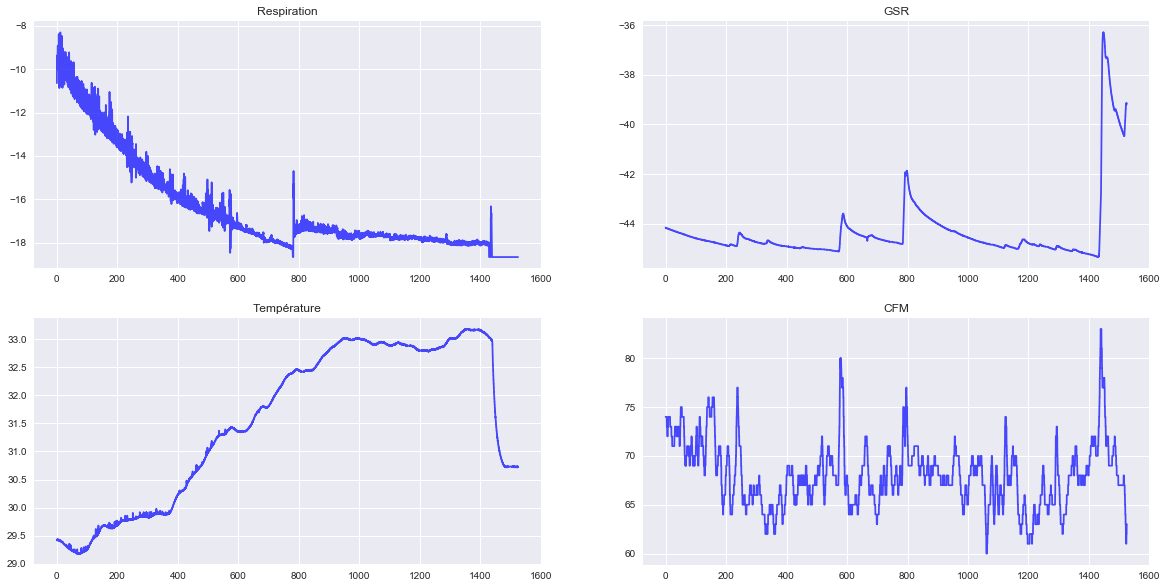

In [64]:
fig = plt.figure(figsize=(20, 10))

ax_respi = fig.add_subplot(221)
ax_GSR = fig.add_subplot(222)
ax_temp = fig.add_subplot(223)
ax_CFM = fig.add_subplot(224)

ax_respi.set_title("Respiration")
ax_GSR.set_title("GSR")
ax_temp.set_title("Température")
ax_CFM.set_title("CFM")

ax_respi.plot(t, respi, color = "Blue", alpha = 0.7)
ax_GSR.plot(t, GSR, color = "Blue", alpha = 0.7)
ax_temp.plot(t, temp, color = "Blue", alpha = 0.7)
ax_CFM.plot(t, CFM, color = "Blue", alpha = 0.7)

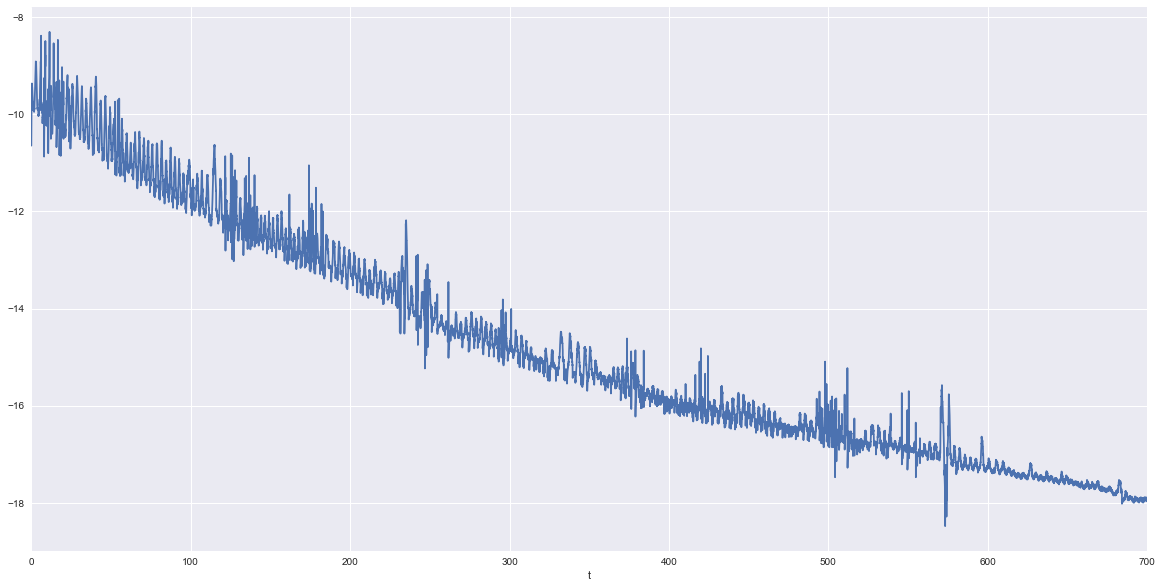

In [20]:
#respi[:700].plot(figsize=(20, 10))

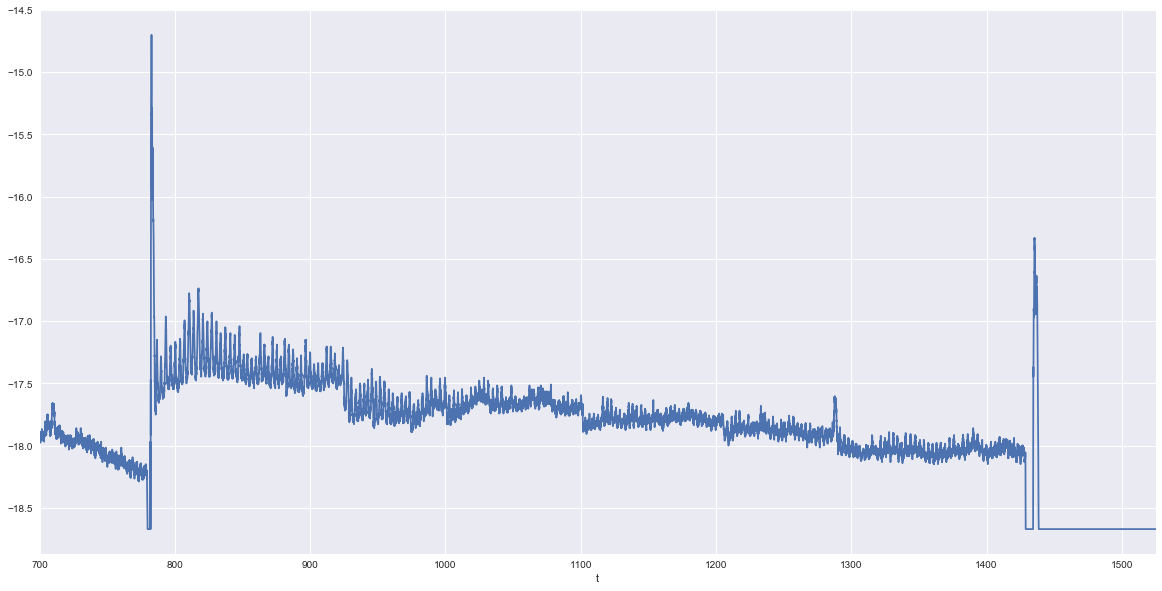

In [11]:
#respi[700:].plot(figsize=(20, 10))

### Statistiques de base

In [18]:
X.describe()

,t,Respiration,GSR,Temperature,CFM
count,48803.000000,48803.000000,48803.000000,48803.000000,48803.000000
mean,762.531375,-16.418439,-44.308595,31.545405,68.092515
std,440.261154,2.261775,1.440691,1.373293,3.352344
min,0.000000,-18.670000,-45.345000,29.180000,60.000000
25%,381.265500,-17.859000,-44.932000,29.993000,66.000000
50%,762.531000,-17.500000,-44.732000,31.795000,68.000000
75%,1143.797000,-15.659000,-44.394000,32.896000,70.000000
max,1525.063000,-8.304000,-36.299000,33.184000,83.000000


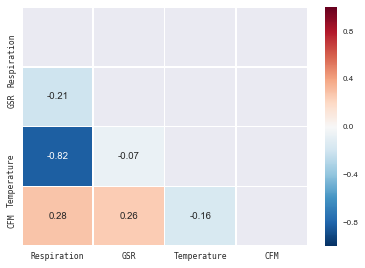

In [19]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 16}

#plt.rc('font', **font)
mat_corr = data.corr()
sns.set(context="paper", font="monospace")
fig = plt.figure()
ax = fig.add_subplot(111)
mask = np.zeros_like(mat_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(mat_corr, mask = mask, annot = True, linewidth = 0.5, fmt = '.2f', ax = ax)
plt.savefig('matrice_correlations.png')

In [20]:
print(mat_corr)

             Respiration       GSR  Temperature       CFM
Respiration     1.000000 -0.205849    -0.821831  0.282836
GSR            -0.205849  1.000000    -0.066991  0.257428
Temperature    -0.821831 -0.066991     1.000000 -0.162729
CFM             0.282836  0.257428    -0.162729  1.000000


### ACP

In [21]:
def proj_ACP(X):
    """
    Affiche les données dans le premier plan factoriel.
    X est la matrice d'entrée (var centrées réduites), y est le vecteur des classes de sortie.
    """
    # ACP 
    #n_components = 2
    pca = PCA()
    X_pca = pca.fit_transform(X[['Respiration', 'GSR', 'Temperature', 'CFM']]) # X est un tableau numpy
    print(X_pca)
    # Affichage
    fig = plt.figure(figsize = (30, 20))
    ax = fig.add_subplot(111, facecolor = 'w')
    nb_points = len(X)
    points = DataFrame(X_pca[:,:2], columns = ['x', 'y'], index = X.index)
    #print(points.head(20))
    cax = ax.scatter(points.x, points.y, s = 20, marker = 'o', alpha = 0.4, c = X['t'], cmap = 'plasma')
    cbar = fig.colorbar(cax)
    return pca

In [22]:
liste_var = ['Respiration', 'GSR', 'Temperature', 'CFM']

[[ 3.32116965  0.51399324 -0.68904676  0.5173562 ]
 [ 3.40110009  0.49098286 -0.69319854  0.59977127]
 [ 3.46474282  0.47266138 -0.69650431  0.66539232]
 ..., 
 [-0.82210411  2.08078737  3.36527823  0.13255841]
 [-0.82197549  2.07422966  3.36063444  0.13036881]
 [-0.82197549  2.07422966  3.36063444  0.13036881]]


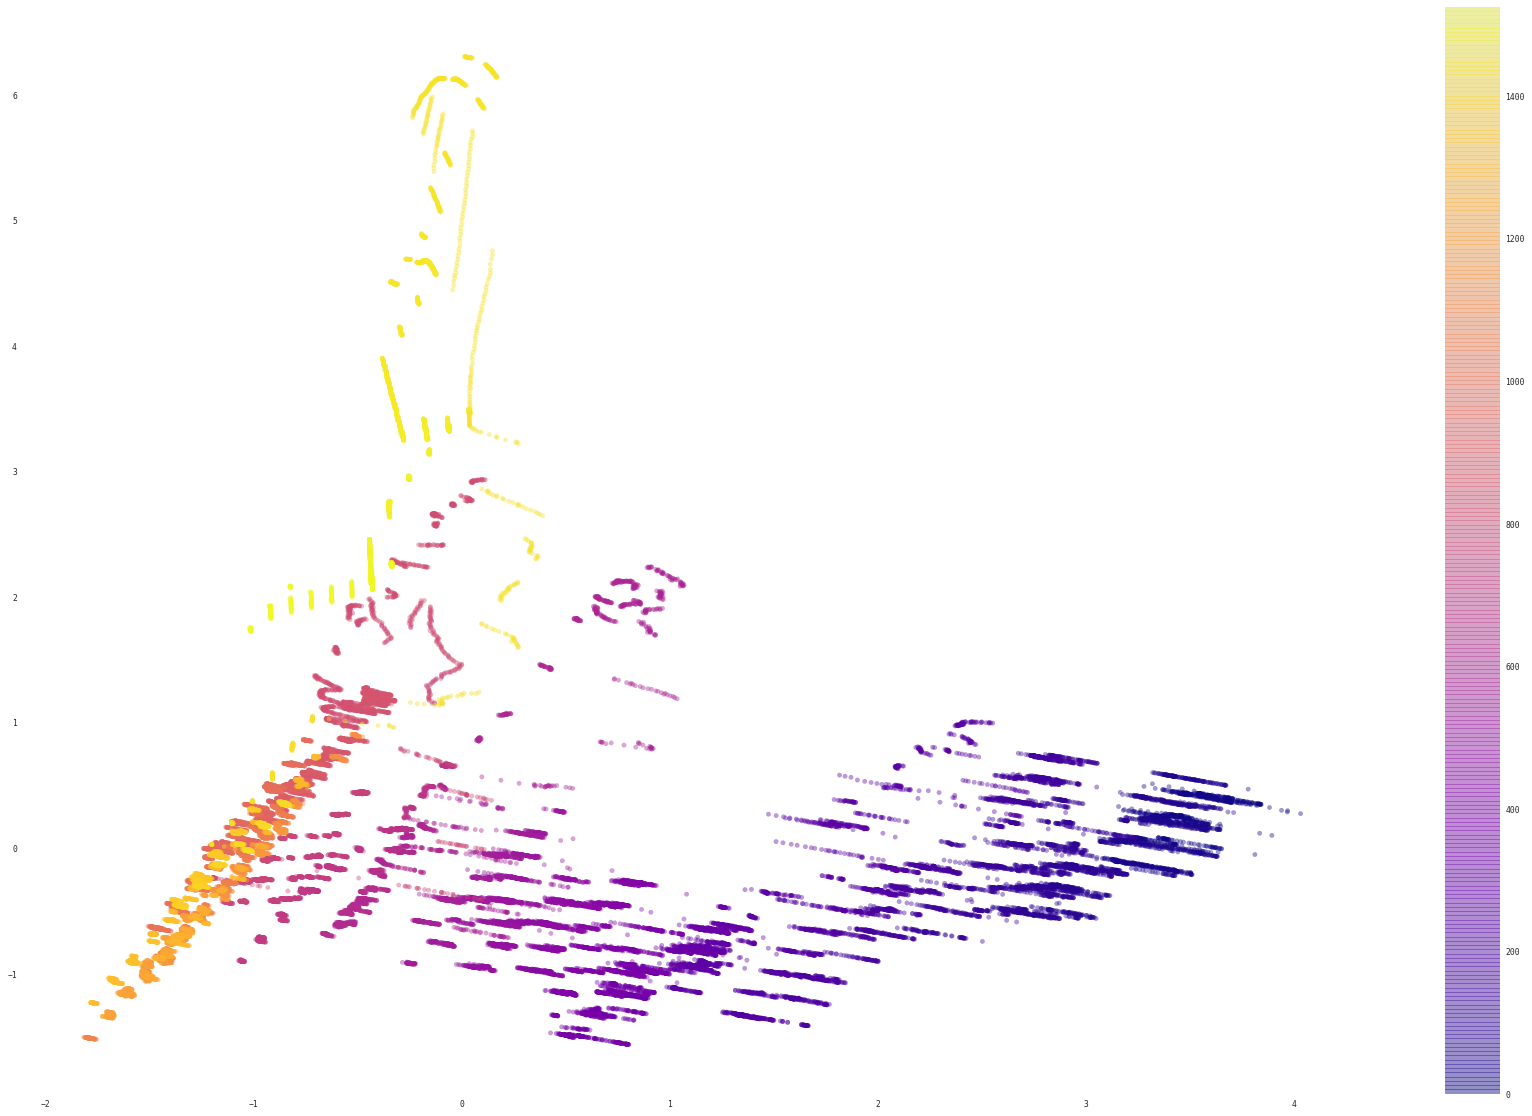

In [23]:
X_norm = DataFrame(StandardScaler().fit_transform(X[liste_var]), columns = liste_var, index = X.index)
X_norm['t'] = X['t']
pca = proj_ACP(X_norm)

   Respiration       GSR  Temperature       CFM      t
0    -1.524213  1.958200     1.168982  1.333269  0.000
1    -0.922111  1.958200     1.168982  1.333269  0.031
2    -0.442701  1.958200     1.168982  1.333269  0.063
3    -0.017821  1.958200     1.168982  1.333269  0.094
4     0.318447  1.744612     1.168982  1.333269  0.125
[[ 1.88532965 -2.06826402 -1.02940354 -0.64034713]
 [ 2.09257571 -1.6042569  -0.70765574 -0.61292096]
 [ 2.25759049 -1.23480217 -0.45147165 -0.59108353]
 ..., 
 [-1.80569307  0.20434974  1.74107026 -0.10423731]
 [-1.80569307  0.20434974  1.74107026 -0.10423731]
 [-1.84870641  0.10804637  1.67429241 -0.10992953]]


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

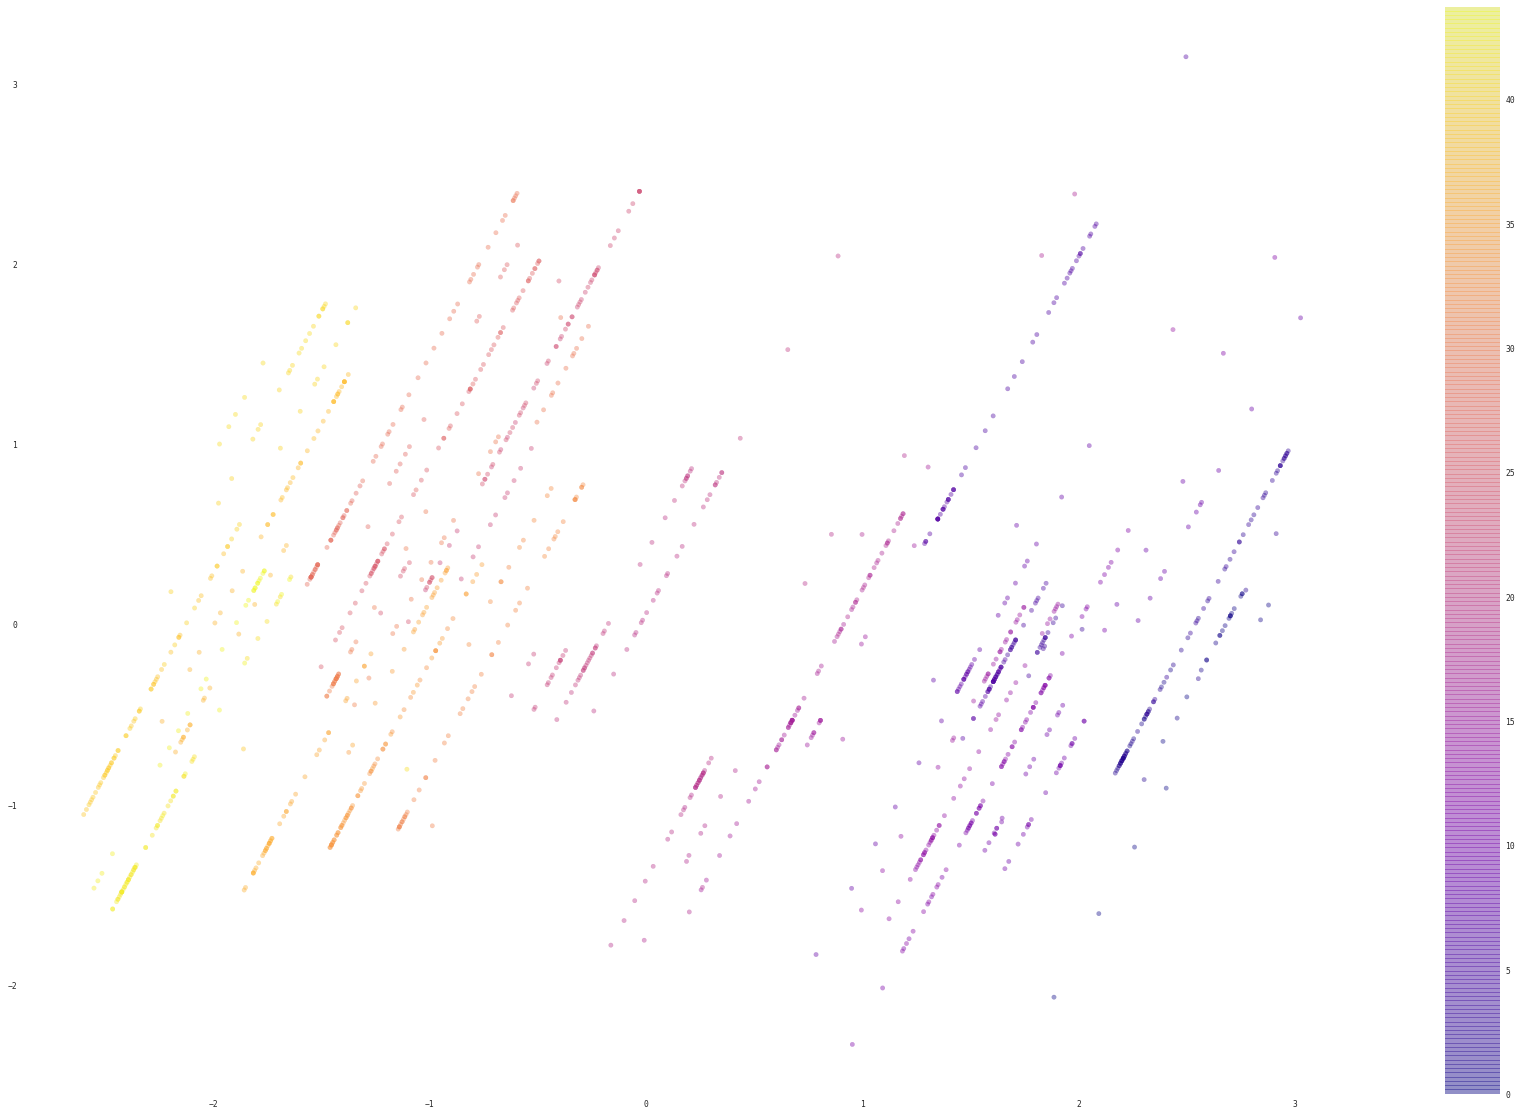

In [24]:
debut = 0
fin = 1400
X_norm = DataFrame(StandardScaler().fit_transform(X[liste_var][debut:fin]), columns = liste_var, index = X.index[debut:fin])
X_norm['t'] = X['t'][debut:fin]
print(X_norm.head(5))
proj_ACP(X_norm)

<Container object of 4 artists>

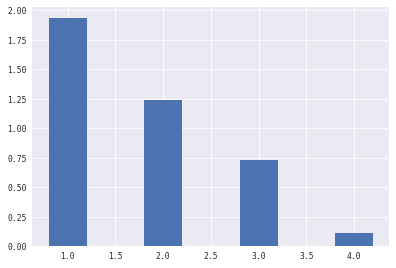

In [25]:
liste_vp = pca.explained_variance_
plt.bar([1, 2, 3, 4], liste_vp, 0.4)

### Spectrogrammes

In [26]:
def affiche_spectrogramme(freq, time, Sxx, title, nom_fichier):
    """
    Affiche le spectrogramme correspondant au triplet freq, time, Sxx.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.pcolormesh(time, freq, Sxx, cmap='plasma', vmax = 2)
    ax.set_ylabel('Fréquence [Hz]')
    ax.set_xlabel('Temps [sec]')
    ax.set_ylim(0, 0.8) # fréquence normale chez l'adulte : entre 0.2 et 0.3 Hz
    cbar = fig.colorbar(cax)
    ax.set_title(title)
    fig.savefig('./Images/Spectrogrammes/' + nom_fichier)

In [37]:
def affiche_spectrogrammes(Y, fs):
    """
    Affiche une matrice de spectrogrammes pour visualiser l'importance du facteur dt (fenêtre)
    pour le calcul des FFT.
    Permet de visualiser la relation d'incertitude entre dt et df (aire des rectangles constante).
    """
    dt = 50 # calcul de la FFT sur dt secondes
    nom_fichier = 'matrice_spectrogrammes'
    fig, ax = plt.subplots(4, 4, figsize = (30, 20))
    dt = 10
    for i in range(4):
        for j in range(4):
            nperseg = fs*dt# nombre de sample par calcul de FFT
            overlap = nperseg-2 # recouvrement entre les fenêtres de calcul de FFT
            freq, time, Sxx = signal.spectrogram(Y, fs=fs, nperseg=nperseg, return_onesided=True)
            title = 'window = ' + str(dt) + ' s, ' + 'overlap = ' + str(overlap) + ' points'
            cax = ax[i, j].pcolormesh(time, freq, Sxx, cmap='plasma', vmax = 2)
            ax[i, j].set_ylabel('Fréquence [Hz]')
            ax[i, j].set_xlabel('Temps [sec]')
            ax[i, j].set_ylim(0, 0.8) # fréquence normale chez l'adulte : entre 0.2 et 0.3 Hz
            #cbar = fig.colorbar(cax)
            ax[i, j].set_title(title)
            dt += 5
    fig.savefig('./Images/Spectrogrammes/' + nom_fichier)

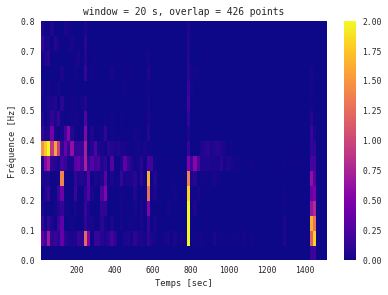

In [28]:
fs = 32 # frequence d'échantillonage = 32Hz
dt = 20 # calcul de la FFT sur dt secondes
nperseg = fs*dt# nombre de sample par calcul de FFT
overlap = 2*nperseg//3 # recouvrement entre les fenêtres de cacul de FFT
freq, time, Sxx = signal.spectrogram(respi, fs=fs, nperseg=nperseg, return_onesided=True)
title = 'window = ' + str(dt) + ' s, ' + 'overlap = ' + str(overlap) + ' points'
nom_fichier = title
affiche_spectrogramme(freq, time, Sxx, title, nom_fichier)

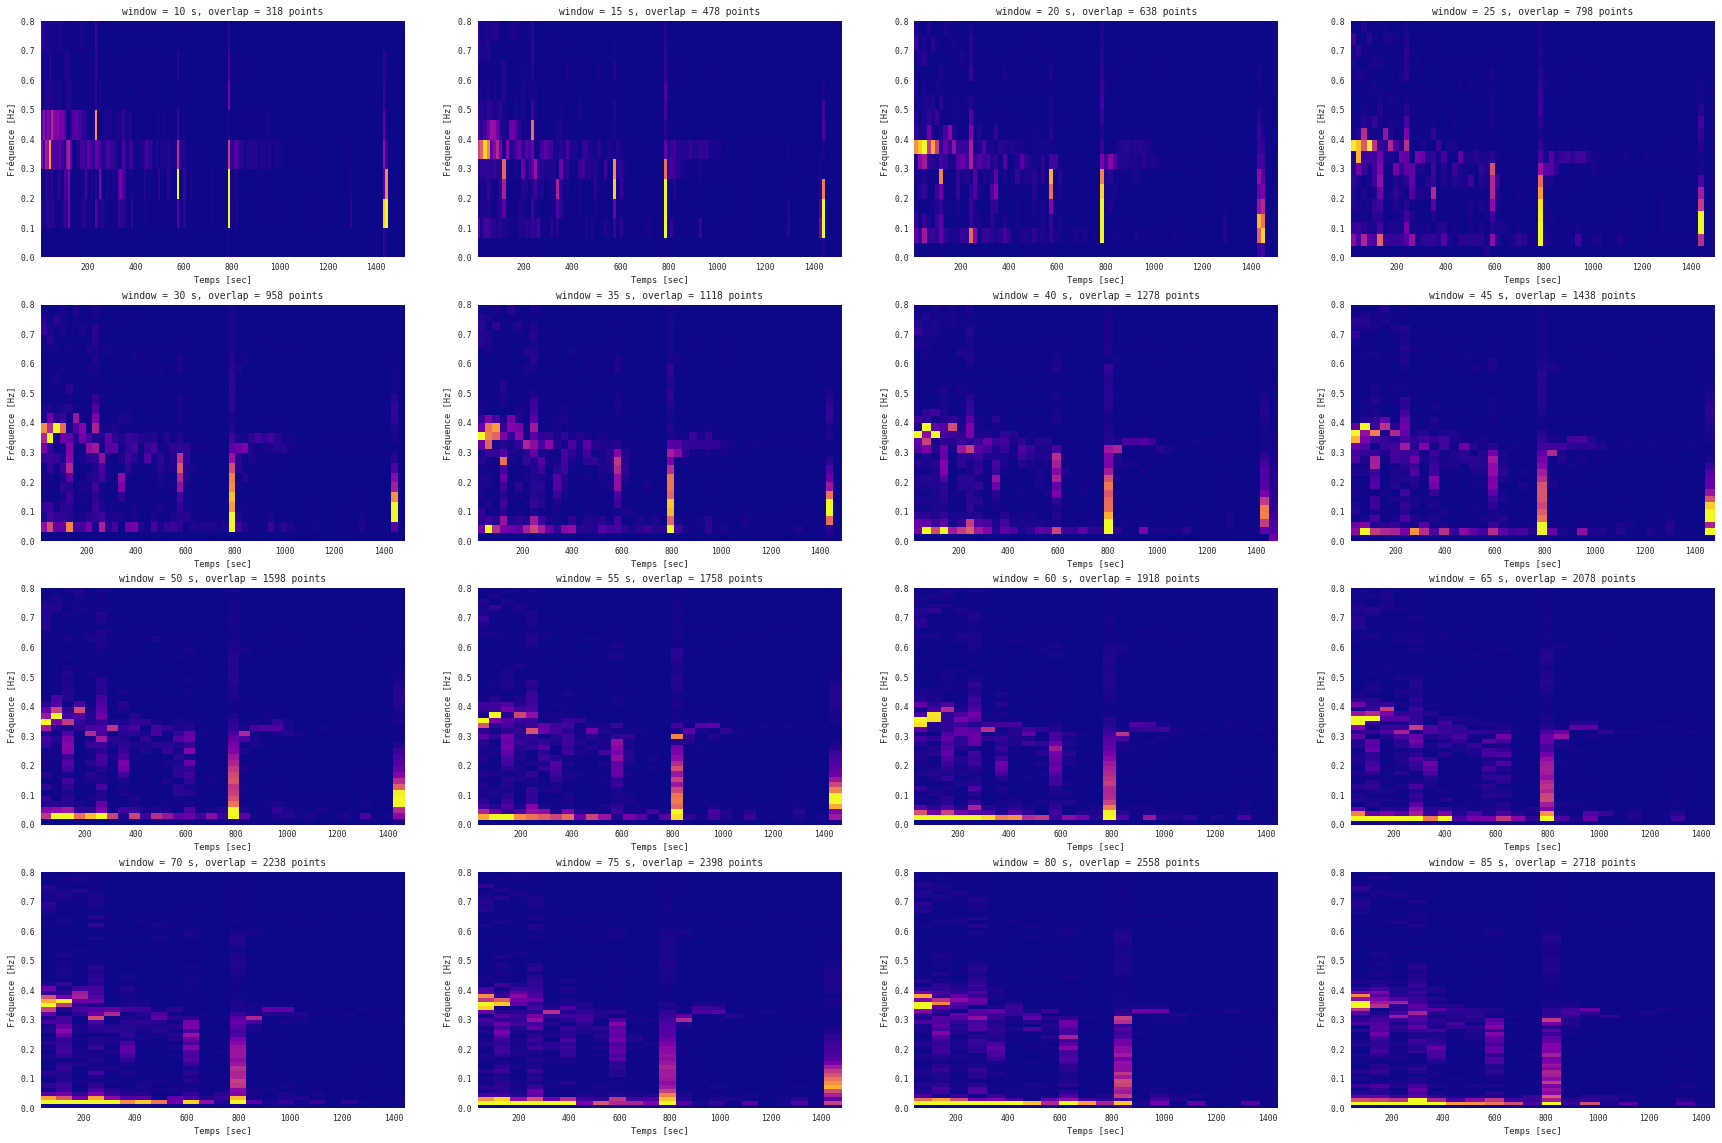

In [38]:
affiche_spectrogrammes(respi, fs)

### FFT

In [30]:
def affiche_fft(t, y, Y):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t, y)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')

    ax[1].plot(freq[:n//2], abs(Y[:n//2]), 'r') # plotting the spectrum
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|')

In [31]:
n = len(respi) # nb d'échantillons
k = np.arange(0, n, 1) #arange(min, max, pas)
freq = k/(t[-1]-t[0]) # les fréquences

In [32]:
#tfY = fft(Y)/n # fft computing and normalization    
# Affichage
#affiche_fft(t, Y, tfY)

### Filtrage des basses fréquences

In [33]:
fc = 1/t[-1] # fréquence de coupure = 1/temps de l'expérience
b, a = signal.butter(4, 2*np.pi*fc, 'high') # permet d'avoir un gain égal à 1 sur la partie passante
output = signal.filtfilt(b, a, respi[:700])

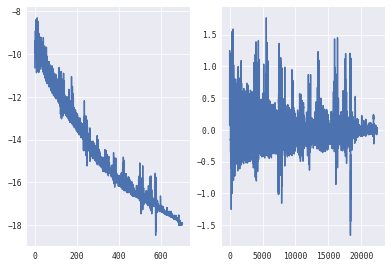

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(respi[:700])
ax2 = fig.add_subplot(122)
ax2.plot(output)

### Fonction d'auto-corrélation

In [74]:
debut = 0
fin = t[-1]
nlags = 1500 # nb de décalages pour le calcul (résolution)
fac_respi = sm.tsa.stattools.acf(output[debut:fin], fft=True, nlags=nlags)
fac_GSR = sm.tsa.stattools.acf(GSR[debut:fin], fft=True, nlags=nlags)
fac_temp = sm.tsa.stattools.acf(temp[debut:fin], fft=True, nlags=nlags)
fac_CFM = sm.tsa.stattools.acf(CFM[debut:fin], fft=True, nlags=nlags)

/Users/Hal/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


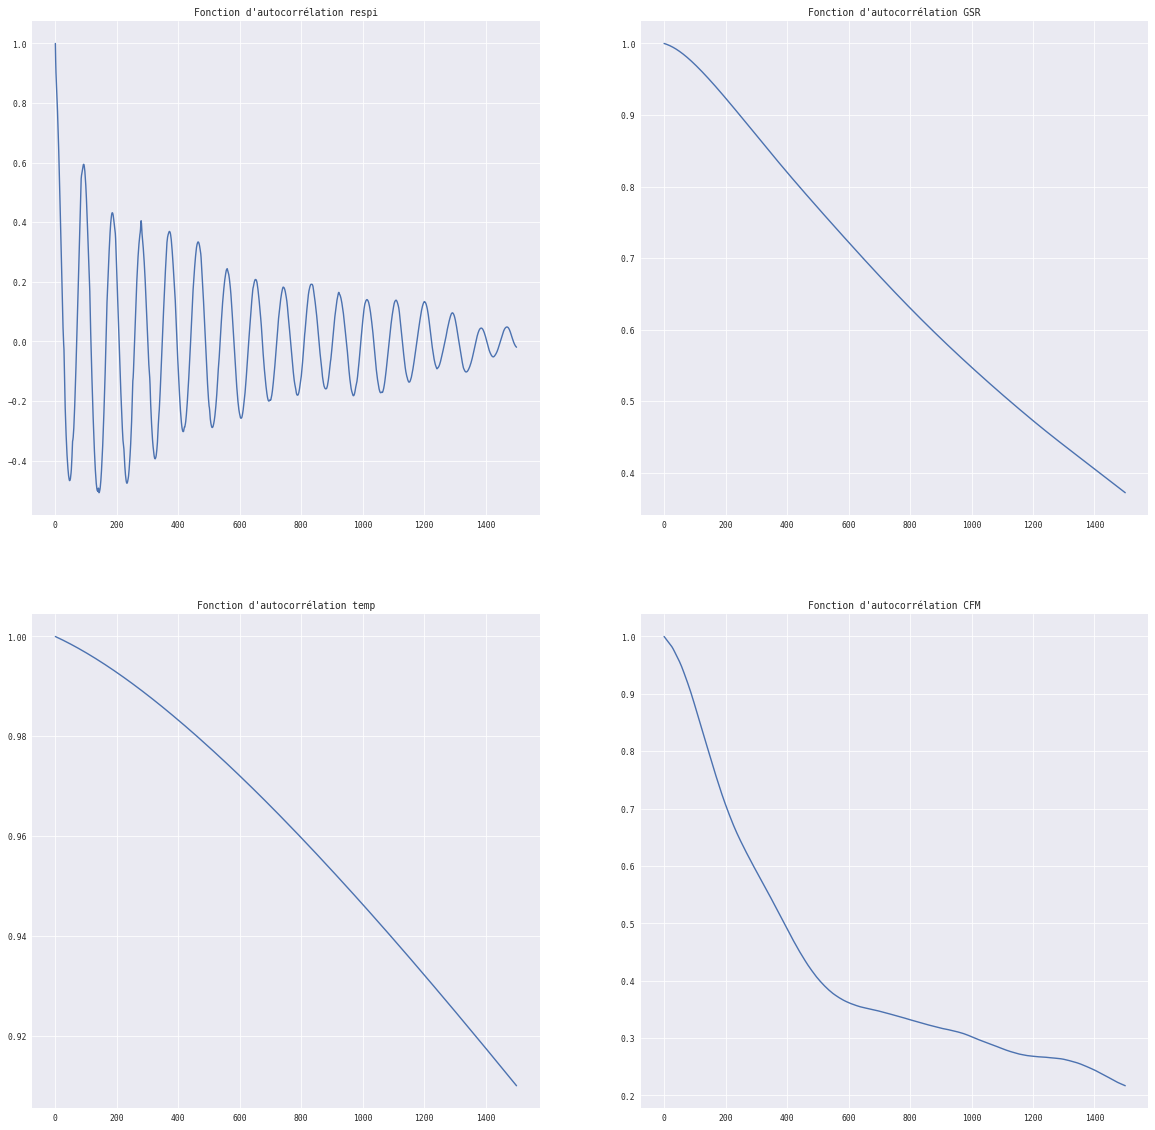

In [75]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(221)
ax1.plot(fac_respi)
ax1.set_title("Fonction d'autocorrélation respi")
ax1 = fig.add_subplot(222)
ax1.plot(fac_GSR)
ax1.set_title("Fonction d'autocorrélation GSR")
ax1 = fig.add_subplot(223)
ax1.plot(fac_temp)
ax1.set_title("Fonction d'autocorrélation temp")
ax1 = fig.add_subplot(224)
ax1.plot(fac_CFM)
ax1.set_title("Fonction d'autocorrélation CFM")